# CNN Cancer Detection Kaggle Mini-Project

## I. INTRODUCTION

The real life challenge of this problem, is that when scan a cell we don't know what can be signal from the scanning result (as an image) to have proper treatment to respective patient, thus it's more effective if we can have a tool to scan through the image and give certain probability that this cell likely to have present of tumor tissue or not.

Thus in this project, we will analyze dataset consists of 200k+ image from patches taken from larger digital pathology scans, aiming to identify the metastatic cancer from those scan result. Images in this dataset have been labeled as tumor tissue present (label = 1) or not (label = 0).

On the other hand, the technical challenge is about handling image data may take time and complexity for task processing, which will need to use CNN on image analysi, by extract feature maps of these image to identify the pattern of cell has tumor tissue

First of all we will do some EDA to understand character of data we have, leverge Convolutional Neural Network to predict in binary class the present of tumor tissue (label 1) or not (label 0). And explore options to optimize the predictive power as well as discussion on respective result.


Reference source of dataset: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

## II. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
let's first explore the dataset, do some analysis to understand the characters there

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
path_train = 'histopathologic-cancer-detection/train_labels.csv'

df_train = pd.read_csv(path_train)

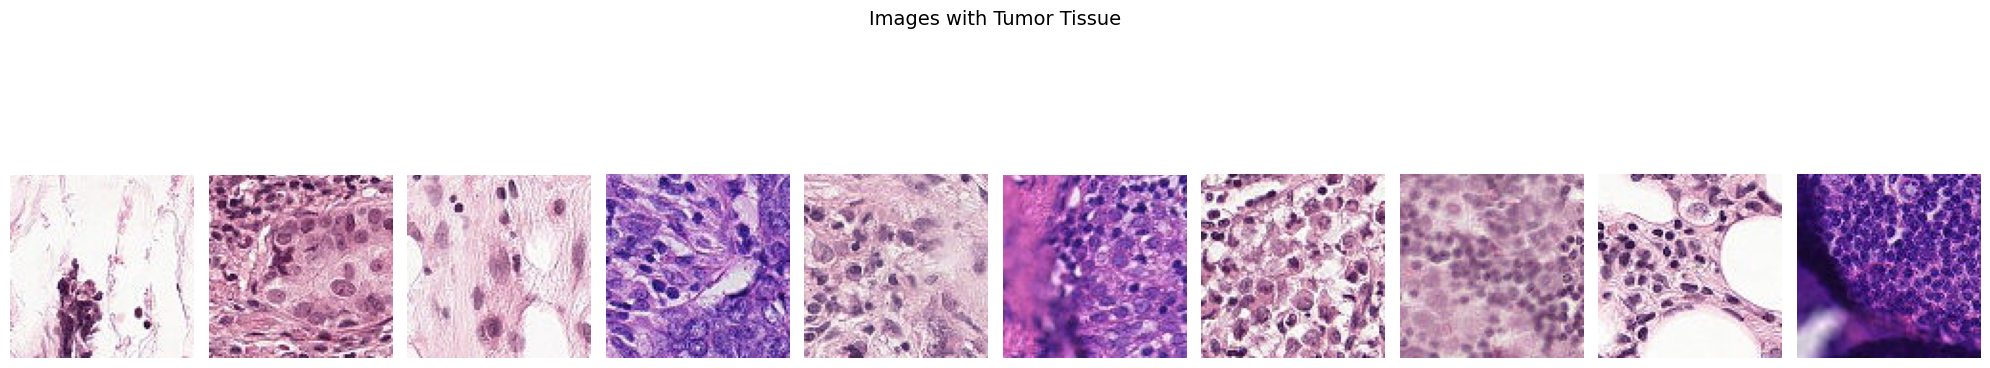

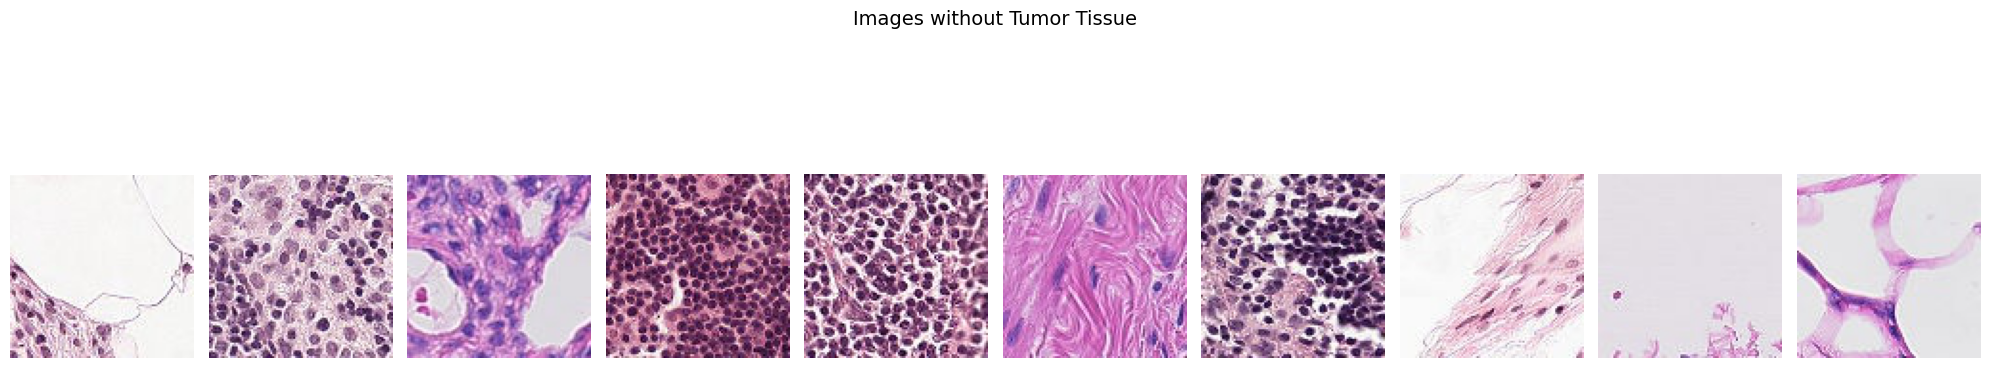

In [3]:
def get_image_paths(df, label, count=10, base_path='histopathologic-cancer-detection/train'):
    return [os.path.join(base_path, f"{img_id}.tif") for img_id in df[df['label'] == label]['id'].head(count)]

def display_images(samples, title, labels=None):
    fig, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, (img_path, ax) in enumerate(zip(samples, axes)):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        if labels:
            ax.set_title(labels[i], fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Display positive and negative samples
display_images(get_image_paths(df_train, label=1), "Images with Tumor Tissue")
display_images(get_image_paths(df_train, label=0), "Images without Tumor Tissue")


**Check sample distribution**

In [4]:
df_train.count()

id       220025
label    220025
dtype: int64

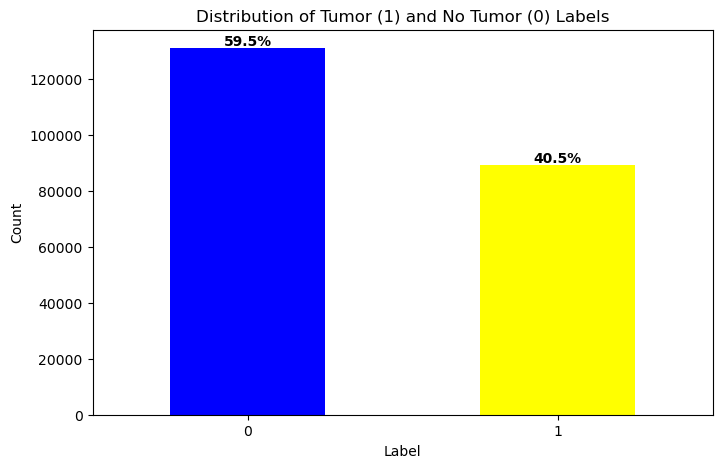

In [5]:
import matplotlib.pyplot as plt

counts = df_train['label'].value_counts()
total = counts.sum()
percentages = counts / total * 100

plt.figure(figsize=(8, 5))
ax = counts.plot(kind='bar', color=['blue', 'yellow'])

for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(i, count + 1, f"{pct:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Distribution of Tumor (1) and No Tumor (0) Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


we have 220k+ in sample size to train and test, also number of sample present tumor tissue is not too low which can be a supportive point to avoid resampling process needed.

**Check image quality to ensure resolution is sufficient for CNN**

In [6]:
path = 'histopathologic-cancer-detection/train'

sample_ids = df_train['id'].sample(10, replace=False).tolist()
image_paths = [os.path.join(path, f'{x}.tif') for x in sample_ids]

for img_id, img_path in zip(sample_ids, image_paths):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    contrast = np.max(img_rgb) - np.min(img_rgb)
    print(f"ID: {img_id}.tif | Resolution: {img.shape[0]}x{img.shape[1]} | Contrast: {contrast}")

ID: d7024ba85251f3d409d49bff7cd927442402ea04.tif | Resolution: 96x96 | Contrast: 255
ID: b6d8523045eb9b87c847edfe3168d5863ef7fdec.tif | Resolution: 96x96 | Contrast: 255
ID: 08b1d5c0a0171dcec6cc5a6e480b018127e38f42.tif | Resolution: 96x96 | Contrast: 254
ID: 4388b304b7df10090376767cf717c99c888439fd.tif | Resolution: 96x96 | Contrast: 255
ID: e1575959548b0067e042a4568af222c0f175b05a.tif | Resolution: 96x96 | Contrast: 255
ID: ed3692221d9e5950d8c2b2828157e34f9d43bb53.tif | Resolution: 96x96 | Contrast: 255
ID: 82e0b6909fee49049fa372055820b5f151cadfa7.tif | Resolution: 96x96 | Contrast: 255
ID: 417a7e91c4011bf2e1fded018b3b8fce68b18205.tif | Resolution: 96x96 | Contrast: 255
ID: 9ff1db9003b68bf3e4bb457b2e3ffd18f66fde82.tif | Resolution: 96x96 | Contrast: 233
ID: 1239ab91afa9f3c4d241238db5ad5a94ca367667.tif | Resolution: 96x96 | Contrast: 255


we have resolution at 96x96 which is higher than 32 x 32 as minimum threshold. We can move to next step for cleaning or preprocessing image to prepare for training session

## III. Model Architecture 
At this part you will find describe model architecture on 2 different approaches and later analysis on each.

We will build first standard CNN using base model of 3 layers  but different approaches:
for baseline model, start at higher detail of extraction and less dense on stack.
for explore mode, start at lower detail of extraction and higher dense on stack.

both use the same learning rate, activation function and optimizer function.

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
print("No GPUs available, using Kaggle standard CPU")
tf.keras.mixed_precision.set_global_policy('float32')

No GPUs available, using Kaggle standard CPU


In [8]:
# first create baseline model and print out the architect

with strategy.scope():
    def create_baseline_model():
        model = models.Sequential([
            
            # 1st convolutional block
            layers.Input(shape=(32, 32, 3)),
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # 2nd convolutional block
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # 3rd convolutional block
            layers.Conv2D(256, (3, 3), padding='same'),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            
            # flatten and dense layers
            layers.Flatten(),
            layers.Dense(256),
            layers.Activation('relu'),
            layers.Dropout(0.5),
            
            layers.Dense(1, activation='sigmoid', dtype='float32')
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )
        
        return model
    
    baseline_model = create_baseline_model()
    baseline_model.name = "Baseline"  

baseline_model.summary()

Model: "Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,419,905 (5.42 MB)

 Trainable params: 1,419,905 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# then create explore model and see the architect
import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Wrap inside strategy if using multi-GPU
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    def create_explore_model(img_width=32, img_height=32):
        model = models.Sequential()
            
        # # Convolutional layers
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # # Fully connected layers
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))  # Binary classification

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )

        return model

    # Create instance
    explore_model = create_explore_model()
    explore_model.name = "Explore"

explore_model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "Explore"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,417 (1.36 MB)

 Trainable params: 356,417 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

more complexity in feature extraction from begin layer in baseline model cause significant larger number of params comparing to explore model.

In [15]:
# COMPARE PERFORMANCE OF THESE MODELS

import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


train_labels_df = pd.read_csv(f'histopathologic-cancer-detection/train_labels.csv')
train_labels_df['label'] = train_labels_df['label'].astype(str)  # Convert label column to string

# data preparing
# Add the .tif extension to the 'id' column for correct file referencing
train_labels_df['id'] = train_labels_df['id'].apply(lambda x: f"{x}.tif")

# Data generators with normalization and validation split
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

batch_size = 32 #if more CPU avai try 64
train_steps = 8000 // batch_size  # 8000 images for training
val_steps = 2000 // batch_size    # 2000 images for validation

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df.head(10000),
    directory='histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    class_mode='binary',
    batch_size=batch_size,
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df.head(10000),
    directory='histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation'
)


baseline_model = create_baseline_model()
explore_model = create_explore_model()


training_callbacks = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

# model training
print("Training Baseline Model...")
history_baseline = baseline_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10,
    callbacks=training_callbacks
)

print("Training Explore Model...")
history_explore = explore_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10,
    callbacks=training_callbacks
)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Training Baseline Model...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6411 - auc_4: 0.6559 - loss: 0.6264 - val_accuracy: 0.7611 - val_auc_4: 0.8249 - val_loss: 0.5080 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7692 - auc_4: 0.8166 - loss: 0.5122 - val_accuracy: 0.7455 - val_auc_4: 0.8312 - val_loss: 0.5332 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7833 - auc_4: 0.8445 - loss: 0.4783 - val_accuracy: 0.7676 - val_auc_4: 0.8201 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7894 - auc_4: 0.8563 - loss: 0.4588 - val_accuracy: 0.7576 - val_auc_4: 0.8477 - val_loss: 0.5001 - learning_ra

## IV. Results and Analysis
At this session we will run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.


In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, val_gen, batch_size=32, threshold=0.5):
    # Adjust steps
    val_steps = int(np.ceil(len(val_gen.classes) / batch_size))
    
    # Predictions
    val_predictions = model.predict(val_gen, steps=val_steps)
    val_pred_classes = (val_predictions > threshold).astype(int).flatten()
    
    # True labels
    true_labels = val_gen.classes
    
    # Ensure lengths match
    val_pred_classes = val_pred_classes[:len(true_labels)]
    val_predictions = val_predictions[:len(true_labels)]
    
    # Metrics
    metrics = {
        "accuracy": accuracy_score(true_labels, val_pred_classes),
        "precision": precision_score(true_labels, val_pred_classes),
        "recall": recall_score(true_labels, val_pred_classes),
        "f1": f1_score(true_labels, val_pred_classes),
        "roc_auc": roc_auc_score(true_labels, val_predictions)
    }

    for k, v in metrics.items():
        print(f"{k.capitalize()}: {v:.4f}")



In [17]:
#baseline model
baseline_result = evaluate_model(baseline_model, val_gen)
baseline_result

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy: 0.5240
Precision: 0.3807
Recall: 0.3128
F1: 0.3434
Roc_auc: 0.4912


In [18]:
#explore model
explore_result = evaluate_model(explore_model, val_gen)
explore_result

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.5290
Precision: 0.3948
Recall: 0.3442
F1: 0.3678
Roc_auc: 0.4963


overall we see explore model perform better than baseline model.
Now let's finetuning the explore model.

In [19]:
def plot_all_metrics(history):
    
    # Extract metrics 
    metrics = [m for m in history.history.keys() 
               if not m.startswith('val_')]
    
    # Create subplots
    n_metrics = len(metrics)
    plt.figure(figsize=(6 * n_metrics, 4))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, n_metrics, i)
        plt.plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

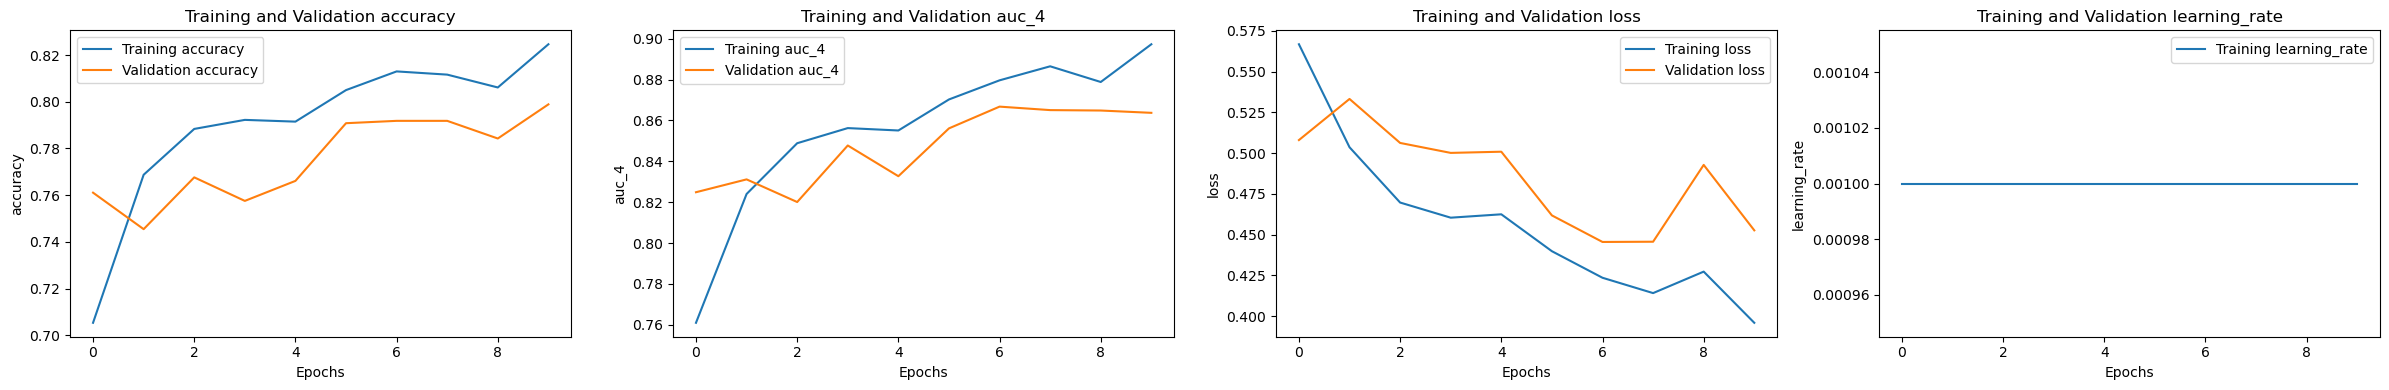

In [20]:
plot_all_metrics(history_baseline)

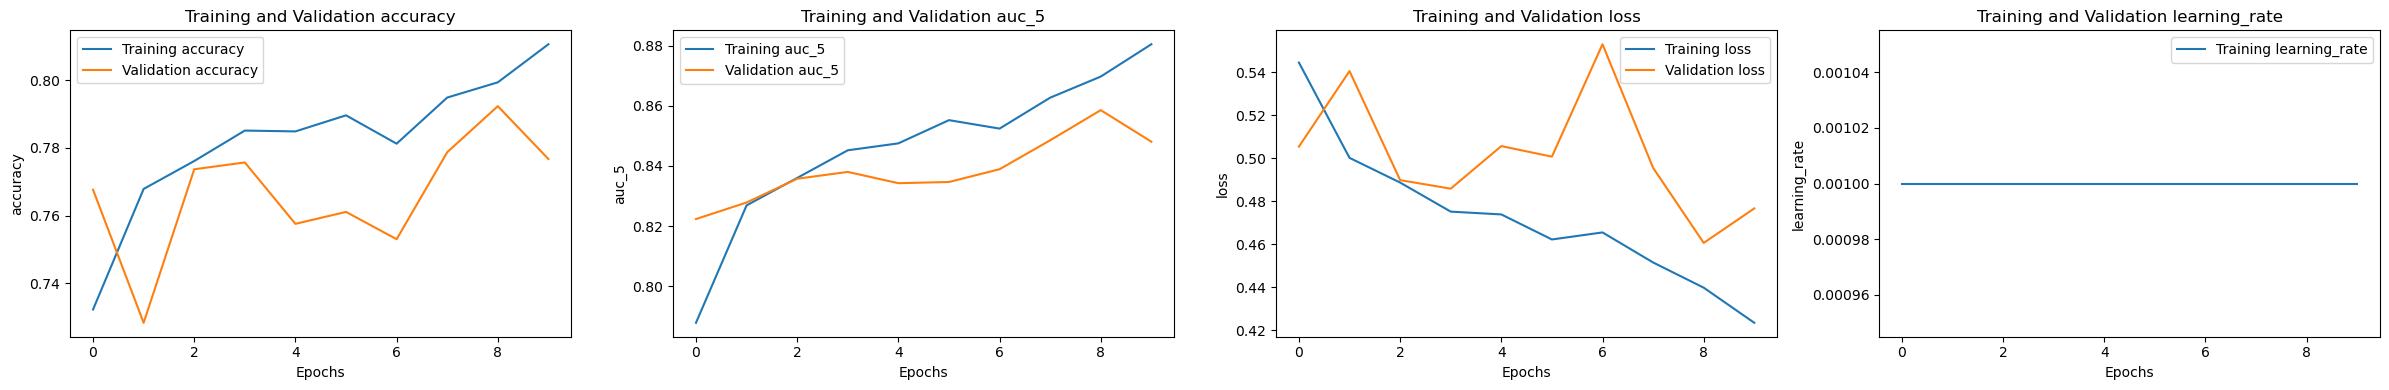

In [21]:
plot_all_metrics(history_explore)

now we try to tuning hyperparams with kernel_regularizer 0.01 to mediate training overfitting.

In [22]:
!pip install keras-tuner

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt

In [25]:
# create optimized model using hyperparams
from tensorflow.keras.regularizers import l2

def optimized_model(hp):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(
        filters=hp.Choice('conv1_filters', values=[32, 64]),
        kernel_size=(3,3),
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(
        filters=hp.Choice('conv2_filters', values=[64, 128]),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(
        filters=hp.Choice('conv3_filters', values=[128, 256]),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    # Dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice('dense_units', values=[256, 512, 1024]),
        activation='relu',
        kernel_regularizer=l2(0.01) #adding to finetuning
    ))
    
    # Dropout
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Optimizer choice
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    
    if optimizer_choice == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_choice == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

In [53]:
tuner = kt.RandomSearch(
    optimized_model,
    objective='val_AUC', #as target of contest is AUC we will aim to find value to optimize this 
    max_trials=10,   # try more combinations since optimizer is added
    executions_per_trial=1,
    directory='tuner_results',
    project_name='cnn_tuning_with_optimizers'
)

tuner.search(train_gen,
             steps_per_epoch=train_steps,
             validation_data=val_gen,
             validation_steps=val_steps,
             epochs=10,
             callbacks=training_callbacks)

# Get best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from tuner_results/cnn_tuning_with_optimizers/tuner0.json


In [27]:
def create_tuning_explore_model(best_hps, img_width=32, img_height=32):
    model = tf.keras.Sequential()
    
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(best_hps.get('conv1_filters'), (3,3), activation='relu',
                                     input_shape=(img_width, img_height, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(tf.keras.layers.Conv2D(best_hps.get('conv2_filters'), (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(tf.keras.layers.Conv2D(best_hps.get('conv3_filters'), (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(best_hps.get('dense_units'), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(tf.keras.layers.Dropout(best_hps.get('dropout_rate')))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Optimizer
    opt_choice = best_hps.get('optimizer')
    lr = best_hps.get('learning_rate')
    if opt_choice == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif opt_choice == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif opt_choice == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model


In [54]:
tuning_explore_model = create_tuning_explore_model(best_hps)

history_tuned = tuning_explore_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10,
    callbacks=training_callbacks
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6391 - auc_1: 0.6489 - loss: 2.1242 - val_accuracy: 0.7445 - val_auc_1: 0.8161 - val_loss: 0.5413 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7624 - auc_1: 0.8197 - loss: 0.5164 - val_accuracy: 0.7631 - val_auc_1: 0.8214 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7747 - auc_1: 0.8280 - loss: 0.5033 - val_accuracy: 0.7429 - val_auc_1: 0.8243 - val_loss: 0.5400 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7672 - auc_1: 0.8212 - loss: 0.5137 - val_accuracy: 0.7651 - val_auc_1: 0.8223 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7806 - auc_1: 0.8409 - loss: 0.4908 - val_accuracy: 0.7611 - val_auc_1: 0.8262 - val_loss: 0.5147 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - 

In [68]:
print('\n explore_result')
baseline_result = evaluate_model(explore_model, val_gen, batch_size=32)

print('\n Tuned_result')
tuned_result = evaluate_model(tuning_explore_model, val_gen, batch_size=32)



 explore_result
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy: 0.5070
Precision: 0.3631
Recall: 0.3166
F1: 0.3383
Roc_auc: 0.4645

 Tuned_result
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.5245
Precision: 0.3869
Recall: 0.3329
F1: 0.3579
Roc_auc: 0.4995


from this result, we see tuned model help to boost the performance slightly better than orgin explore model. Let's see what is other effect and different from these 3 models.

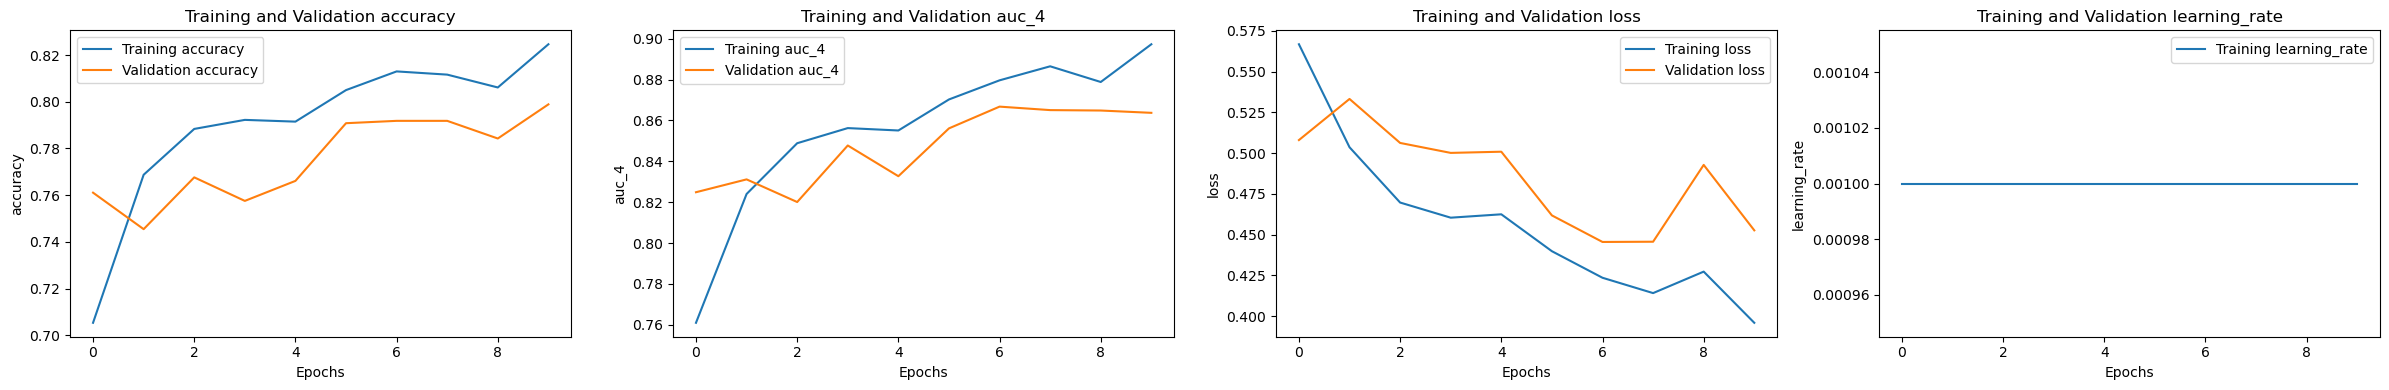

In [56]:
plot_all_metrics(history_baseline)

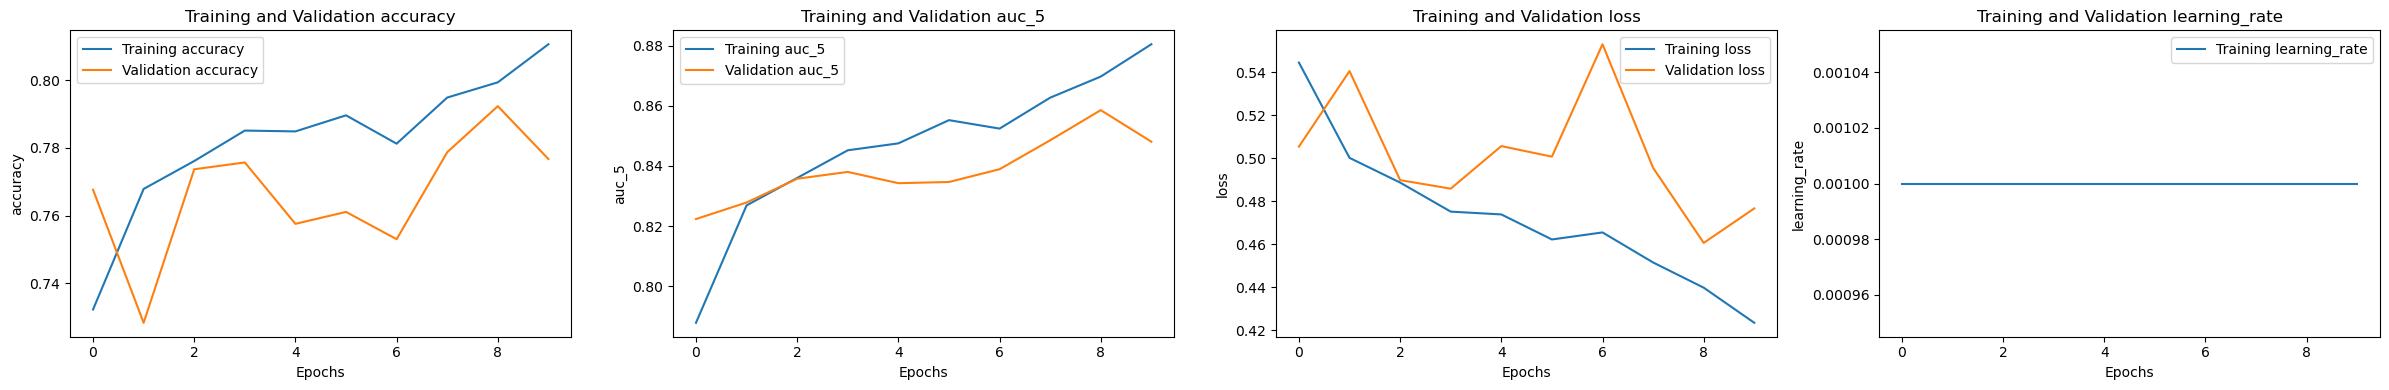

In [69]:
plot_all_metrics(history_explore)

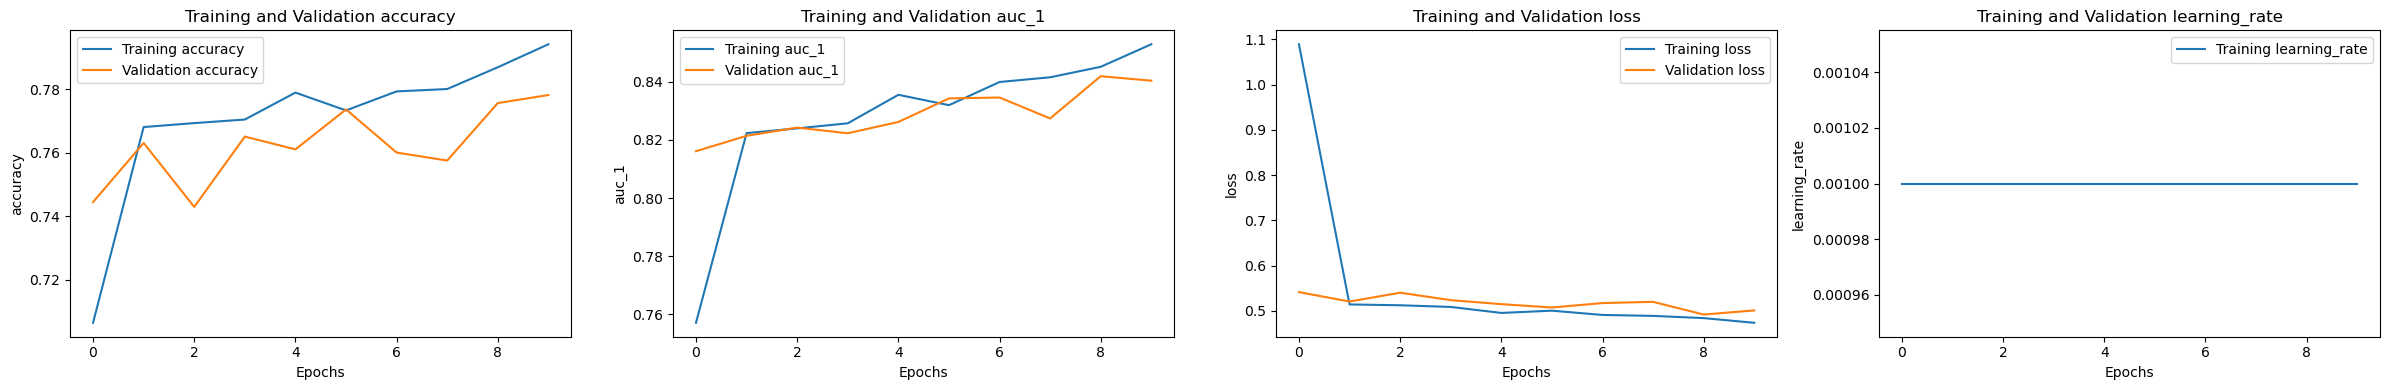

In [70]:
plot_all_metrics(history_tuned)

as we observe the tuned model help to reduce the loss in faster manner, at initial epoch comparing to others can only reach it after 8+ epoch, indicate more efficient in computing process to reach similar result of prediction (indicate through AUC show no significant change).

With this observed, we will use tuned model to predict the test set and submit result to Kaggle to see how is performance observed there.

### now let's use this model to predict the test set and submit to Kaggle...

In [59]:
# import testset
path_test = 'histopathologic-cancer-detection/sample_submission.csv'
path_test_sample = 'histopathologic-cancer-detection/test'
df_test = pd.read_csv(path_test)

In [60]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


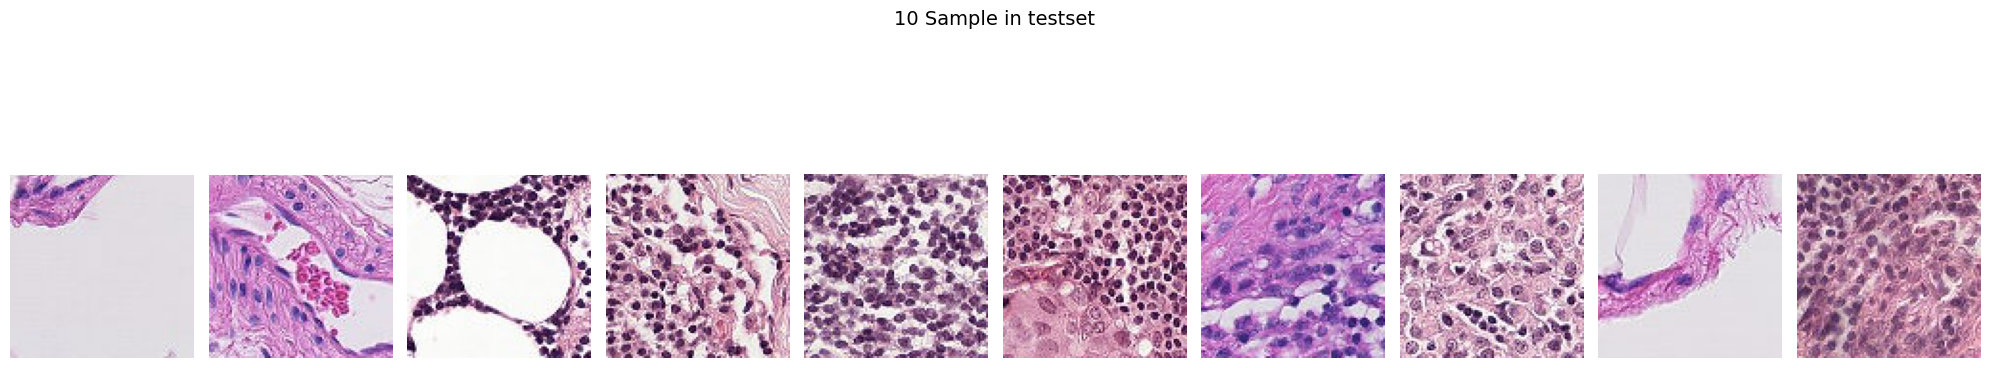

In [61]:
def get_image_test(df, label, count=10, base_path = path_test_sample):
    return [os.path.join(base_path, f"{img_id}.tif") for img_id in df[df['label'] == label]['id'].head(count)]

def display_images(samples, title, labels=None):
    fig, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, (img_path, ax) in enumerate(zip(samples, axes)):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        if labels:
            ax.set_title(labels[i], fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Display positive and negative samples
display_images(get_image_test(df_test, label = 0), "10 Sample in testset")

In [62]:
df_test['filepath'] = df_test['id'].apply(lambda x: os.path.join(path_test_sample, f"{x}.tif"))

In [63]:
#resize to model's size
IMG_SIZE = (32, 32)

def load_and_preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype("float32") / 255.0
    return img

# Convert all test images into numpy array
X_test = np.array([load_and_preprocess_image(p) for p in df_test['filepath']])

In [64]:
y_pred_probs = tuning_explore_model.predict(X_test)

# Convert to binary labels (0/1) using threshold 0.5
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [65]:
df_result = pd.DataFrame({
    "id": df_test['id'],
    "label": y_pred_labels
})

df_result.to_csv("tuned_predictions.csv", index=False)


we achieve 0.70+ AUC score on prediction to the testset.

## V. Conclusion 
in this part we will discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of models and which improvements to try in the future.


as the baseline model approach is extracting more complex feature at starting step and apply lower density, which help to stablize the performance. However look on training result, we see it also causes overfitting problem.
on the other hand, using less complex feature extraction approach and higher density when stacking in explore model, this approach helped to boost the prediction accuracy however also face higher overfitting effect.
as we aim to keep high accuracy score, the tuned model using hyperparams with generalization resulting more efficient and stable performance in faster manner, win over the baseline and explore model.


**Further work:** 

as plateaued AUC in this tuned model at 0.7, we still have more rooms to explore, such as additional preprocssing image to improve quality as part of image augmentation or training in smaller learning rate - while it may increase total training time but help to stablize the model, help to reduce the gap of prediction when stratify data across training pool.

## VI. Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard 


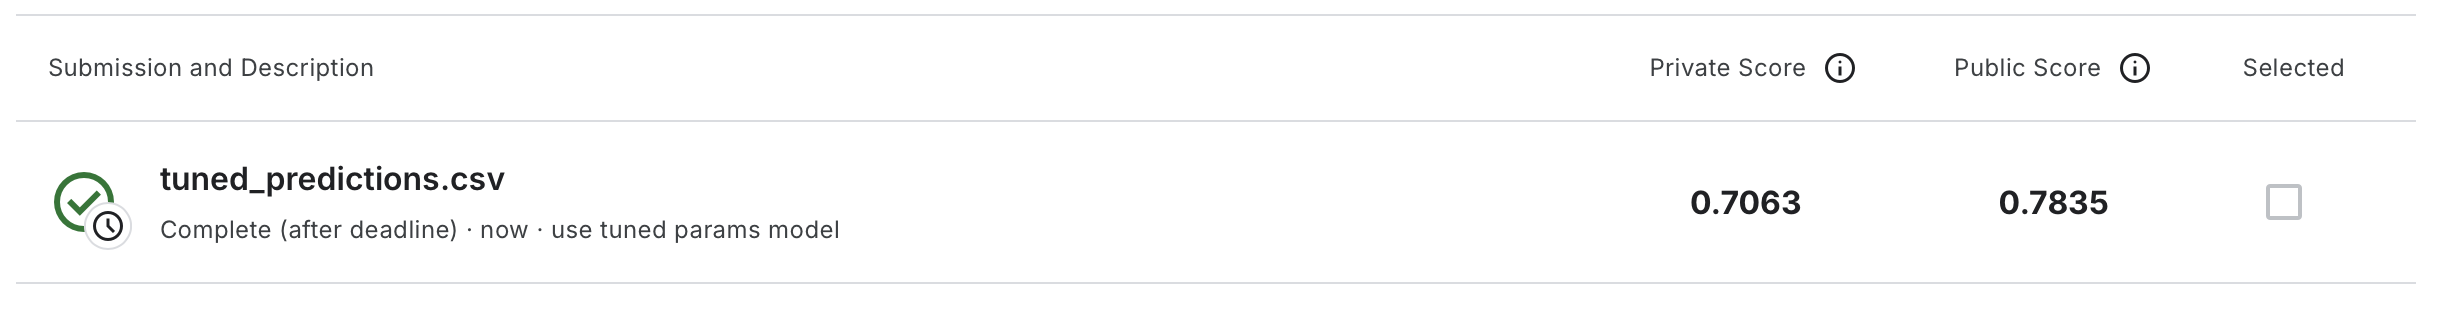

In [66]:
from IPython.display import Image, display
display(Image(filename='Kaggle result.png'))

as submittion is after deadline of the competition, the position in Kaggle do not applied.

# Github link:
https://github.com/GabyVothy/DeepLearning/blob/main/Histopathologic%20Cancer%20Detection.ipynb
